In [4]:
import calim
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

color_palette = sns.color_palette("colorblind")
sns.set_theme(palette=color_palette, font="Arial", font_scale=1.0, style="white")

# number of iterations and seed for bootstrapping during calculation of confidence intervals
n_boot = 10000
seed = 10

In [5]:
#Stand Kalibration 10.03.2020 für das Scientifica-Setup
# mit Korrektur vom 19.05.2021 (ab hier zu verwenden)
kd = 417.1324107961717
R_max = 1.9267297757725788*1.305670312829699
R_min = 0.27585714285714286*0.8222568831620652
sf2_by_sb2 = 2273/413



def calcium(data, kd, R_max, R_min, sf2_by_sb2):
    return kd*((data-R_min)/(R_max-data))*sf2_by_sb2

In [6]:
# Names of used data files

filename_1 = "doppel_perf_fura_data+ctrl_burst_selection_230601.hdf"

In [7]:
# import data

data_pkl_1 = calim.Project()
data_pkl_1.from_hdf(filename_1)

In [8]:
# Process recordings from data files
# The DataFrame "conditions" will contain all information about conditions
# data is "start corrected"
data_1 = pd.DataFrame()

data_info = pd.DataFrame()


print(f"Processing recordings contained in {filename_1}:")

for recording in data_pkl_1.recordings:
    print(recording)
    
    r = data_pkl_1.recordings[recording]

    info = {desc: r.information[desc] for desc in r.information}
    
    for cell in r.cells:
        c = r.cells[cell]
        
        if c.use:
            print(c.cell_id)
            print(c.raw_data.mean())
            raw_data = c.raw_data

            cell_binned = pd.DataFrame()
            last_frame = 0
            burst_list = [x.frame for x in c.baseline if x.use] # Get list of burst frames
            
            baseline_list = range(0, len(c.raw_data))
            baseline_list = [x for x in baseline_list if x not in burst_list] # Get list of baseline frames
            
            # list of raw baseline values
            c_raw_baseline = [c.raw_data[int(i)] if i in baseline_list else np.nan for i in range(0, len(c.raw_data))] 
        
        

            for con in r.conditions:
                info["recording"] = recording
                info["start"] = int(con.start)
                info["end"] = int(con.end)
                start = int(con.start)
                end = int(con.end)
                info["cell"] = cell
                info["dt"] = r.dt # Add "dt" aka seconds/frame
                info["date"] = info["recording"][0:6]
                
                info.update({desc: con.information[desc] for desc in con.information}) # Add all further condition variables
                data_info = pd.concat((data_info, pd.DataFrame.from_dict(info,orient='index').T))
                pos_len = (int(con.end) - int(con.start))*r.dt/60
                            
                a = np.empty(0)

                if info["pos"] == "1":
                    start = int(end-300/r.dt) #take last 5 min of pos 1
                
                if info["pos"] == "4":
                    if len(c.raw_data[start:end]) < 6000:
                        a = np.empty(6000-len(c.raw_data[start:end]))
                        a[:] = np.nan
                    pos_len = 10 #10 mins
                    end = int(int(con.start) + 600/r.dt)
                
                                  
                calcium_baseline_array = np.concatenate((c_raw_baseline[start:end], a), axis=None)
                
                binned_Ca_baseline = calcium(calcium_baseline_array, 
                                           kd, R_max, R_min, sf2_by_sb2).reshape(-1, 600) #group to bin 1min
        
                #drop bin if less then 10 s of data
                binned_Ca_baseline = [i.tolist() if len(i)-np.count_nonzero(np.isnan(i)) >= 10*r.dt \
                                   else [np.nan for j in i]\
                                      for i in binned_Ca_baseline] 
                

                #calculate mean per bin, ignore nan
                binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
                
                
               
                
                                
                if info["pos"] == "1":
                    binned_Ca_bb = pd.DataFrame({'baseline_ca': binned_Ca_baseline},\
                                                index=[*np.arange(-4, 1, 1)]) #bin 1min
                else:
                    binned_Ca_bb = pd.DataFrame({'baseline_ca': binned_Ca_baseline},\
                                                      index=[*np.arange(last_frame+1, last_frame+pos_len+1, 1)]) #bin 1min
                    last_frame = last_frame+10
                    
                binned_Ca_bb["pos"] = info["pos"]
                cell_binned = pd.concat((cell_binned, binned_Ca_bb))
                            
            cell_binned["cell"] = cell
            cell_binned["recording"] = recording
            cell_binned["animal"] = info["animal"]
            cell_binned["ctrl"] = info["ctrl"]
            cell_binned = cell_binned.reset_index().rename(columns={"index": "bin"})
            data_1 = pd.concat((data_1, cell_binned), ignore_index=True)

                

                
                

Processing recordings contained in doppel_perf_fura_data+ctrl_burst_selection_230601.hdf:
230223_slice03_ttap2_isra_ctrl_results.csv
Mean1
0.8327429979253113


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean11
0.9033752593360995


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean12
0.9056890127939142


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean13
0.8709125172890734


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean16
0.8885429201244812


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean18
0.889659362033195


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean2
0.814349152835408


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean20
0.8869330048409405


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean21
0.9982503025587829


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean22
0.9896615231673582


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean23
0.9508517894190871


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean24
0.8440869640387276


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean25
0.9585111946749654


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean3
0.9760424878976489


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean4
0.7892149896265559


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean5
0.8640294346473028


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean6
0.81341869813278


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean7
1.0131869813278007


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean9
1.0220660442600278


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


230223_slice04_ttap2_isra_results.csv
Mean1
0.8326065788916642


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean10
0.8340117691884341
Mean11
0.9521753101054147
Mean12
0.9008305321535921


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean13
0.9693432538842557
Mean14
0.9346186020913593
Mean15
0.9405767749036874


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean16
0.9170526226662715


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean17
0.8936519199017822


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean18
0.8946158079674866


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean19
0.8879289191820837


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean2
0.845361839041531


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean21
0.9233912196774057
Mean3
0.842700690063926
Mean4
0.8549894585326615
Mean5
0.8134060370009737


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean6
0.9212327589856483


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean7
0.8212325473095974


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean8
0.8668215147538207
Mean9
0.8296210575335506


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


230224_slice01_ttap2_isra_ctrl_results.csv
Mean1
0.9335726378907454


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean10
0.9435087077289361


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean12
1.0173832723424894


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean13
0.8717453815969314
Mean14
0.9589529121290947


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean15
0.923496142145408


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean16
0.9075744896609497


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean19
0.8747076407565804


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean2
0.9216882853489704


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean20
0.9177890304660288


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean21
0.9378364269653013


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean22
1.0532946078215246


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean23
0.990504386931793


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean24
0.9549158326352454


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean26
0.9031386182267096


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean27
0.9680016313213704


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean28
0.9527236012521493


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean29
0.949896918125303


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean3
0.8465506370971296


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean30
0.9794033772761341


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean31
0.9759546757197654


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean32
0.9958843084520083


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean33
0.9580145937127992
Mean34
0.9296909307349764
Mean5
0.9290140646355981


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean6
0.7657687932630837


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean7
0.8681810325823376


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean8
0.8619806005026235
230224_slice04_ttap2_isra_results.csv
Mean1
0.8872983795366278


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean10
0.9137636266238115


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean11
0.8873453417258159


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean12
0.9428415695727869


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean13
0.8789568769251372


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean14
0.8476178295611804
Mean15
0.9997337618856301


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean17
0.9036964867639838
Mean18
0.8699650908441585
Mean19
0.9859892415517163


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean2
0.9014709164769429


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean20
0.9059875451988751
Mean21
0.9786914423463239
Mean22
0.9341620909780813


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean23
1.0546888531761975


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean24
0.9990886121155307


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean25
0.8620125440828534


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean26
0.8780457568858533


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean27
0.8663727065755992


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean28
0.8773907861256194


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean29
0.8857285835453773


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean3
0.7994970760233918
Mean30
0.9637023347172001


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean31
0.9477990268291594
Mean32
0.8431500825855988
Mean33
0.9785973394044909


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean34
0.8753390027230926
Mean35
0.8605593500290165


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean36
0.931135842149904


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean37
0.8812305254229722


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean38
0.8469980358019731
Mean39
0.9268846480067854


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean4
0.9912538725949733
Mean40
0.9067149234409179
Mean5
0.9019075934110083


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean6
0.9055028346948798


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean7
0.9180152671755725


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean8
0.8396297486719342


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean9
0.8965812686933621


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


230224_slice06_ttap2_isra_ctrl_results.csv
Mean1
0.8257424997774415


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean10
0.9870057865218552


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean11
0.904197008813318


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean12
0.9180806107006143
Mean14
1.0220324045223894
Mean15
0.9546671859699101


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean16
0.909152719665272


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean2
0.9810566634024749


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean3
0.9832760170924952
Mean4
0.9586913558265824


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean5
0.8840083682008367


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean6
0.8557137452149916


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean7
0.8589410665004897


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean8
0.8564007388943291


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean9
0.877232929760527


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


230227_slice03_ttap2_isra_results.csv
Mean1
0.7185661219062326
Mean10
0.8463247115343372


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean11
0.8273360356882427
Mean12
0.9348928065885986
Mean13
0.8641652725946897


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean14
0.8636289194869816


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean15
0.8422955432591257


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean16
0.9138206580019731


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean17
0.8490299403766138
Mean18
0.8535390125680951


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean19
0.894014155192382
Mean2
0.8379422639728905


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean20
0.8633582550508299


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean21
0.9163986616909021


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean22
0.896721271393643


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean3
0.7791480289966972
Mean4
0.8148777935057693
Mean5
0.8047534422854202
Mean6
0.8098851284690944
Mean7
0.8319117659674862


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean8
0.8560538755200962


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean9
0.7738373868656974
230227_slice04_ttap2_isra_ctrl_results.csv
Mean1
0.9536836426605096


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean2
0.823836737412308


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean3
0.9039863244827281
Mean4
0.9193128052570819


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean5
0.8283778971672142
Mean6
0.8534947606784478


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean7
0.9601031435929314
230228_slice03_ttap2_isra_results.csv
Mean1
0.7539603744149765


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean10
0.8418016492088255


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean11
0.8778023623802095


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean12
0.7940080677512815


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean13
0.8399361265879205


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean14
0.7515070202808112
Mean19
0.8532324047247605
Mean2
0.8293674615556053
Mean20
0.8637880098061065
Mean21
0.8596600846891019


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean22
0.8375148651660352
Mean23
0.8613377312235347
Mean24
0.8906353019835078


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean3
0.7667586360597283
Mean4
0.7904959661243594


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean5
0.7748143525741029


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean6
0.8240685090260753
Mean7
0.7950390907064855


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean8
0.8209904167595277


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean9
0.8291649208825497


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


230228_slice04_ttap2_isra_ctrl_results.csv
Mean1
0.9157637631892632


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean2
0.872513001633482


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean3
0.7839372654628937


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean4
0.8476609862699218


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


230302_slice08_ttap2_isra_results.csv
Mean1
0.7340784988810466
Mean10
0.7516301428817352
Mean11
0.7801760199690136
Mean13
0.7623974436219659
Mean14
0.7791440006885868
Mean15
0.754790626613875
Mean16
0.7715369254604924


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean17
0.7555025391633673
Mean2
0.7797679462902394


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean3
0.7666846273024618


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean4
0.7045988552246515


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean5
0.7054476674126355
Mean6
0.7559533482527112


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean7
0.7704618264761577


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean8
0.7464356171458082


C:\Users\dinhha\AppData\Local\Temp\ipykernel_14704\2725347921.py:77: RuntimeWarning: Mean of empty slice
  binned_Ca_baseline = np.nanmean(binned_Ca_baseline, axis=1)


Mean9
0.7339641074195214


In [9]:
data_1.to_csv("doppel_perf_fura_bbCa_binned.csv")

In [10]:
data_1 = pd.read_csv("doppel_perf_fura_bbCa_binned.csv", index_col="Unnamed: 0")

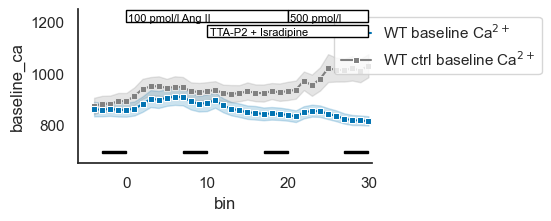

In [12]:
fig1, ax1 = plt.subplots(figsize=(3.8,2))

y_cat1 = "baseline_ca"

y_cat2 = "burst_ca"

##### baseline

sns.lineplot(data=data_1[data_1["ctrl"]=="n"], x="bin", y=y_cat1,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             marker ="s", ms = 5,
                 color=color_palette[0], ax=ax1, zorder=10, label="WT baseline Ca$^{2+}$")

sns.lineplot(data=data_1[data_1["ctrl"]=="y"], x="bin", y=y_cat1,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             marker ="s", ms = 5,
                 color="grey", ax=ax1, zorder=1, label="WT ctrl baseline Ca$^{2+}$")   




    
# Create a Rectangle patch isra/ttap2

ax1.add_patch(plt.Rectangle((0, 1200),20, 48, facecolor='w', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=20))
plt.text(0.2, 1205, "100 pmol/l Ang II", ha="left", color="black", zorder=25, size=8) 

ax1.add_patch(plt.Rectangle((20, 1200),10, 48, facecolor='w', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=20))
plt.text(20.3, 1205, "500 pmol/l", ha="left", color="black", zorder=25, size=8) 

ax1.add_patch(plt.Rectangle((10, 1140),20, 48, facecolor='w', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=20))
plt.text(10.4, 1150, "TTA-P2 + Isradipine", ha="left", color="black", zorder=25, size=8) 

ax1.add_patch(plt.Rectangle((-3,690),3, 6, facecolor='black', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=0))
ax1.add_patch(plt.Rectangle((7,690),3, 6, facecolor='black', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=0))
ax1.add_patch(plt.Rectangle((17,690),3, 6, facecolor='black', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=0))
ax1.add_patch(plt.Rectangle((27,690),3, 6, facecolor='black', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=0))

sns.despine(top=True, right=True)

#ax1.set_xlabel("bins (min)")
#ax1.set_ylabel("Mean [Ca$^{2+}$]$_i$ (nmol/l)")

plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1))

plt.xlim(-6,30.5)
plt.ylim(650,1250)
